In [22]:
# !wget https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv

In [23]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score

In [ ]:
df = pd.read_csv("jamb_exam_results.csv")
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.head().T

In [25]:
del df['student_id']

In [ ]:
df.isna().sum()

In [27]:
df = df.fillna(0)

In [28]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [ ]:
len(df), len(df_full_train), len(df_train), len(df_test), len(df_val)

In [30]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [31]:
y_train = df_train["jamb_score"].values
y_val = df_val["jamb_score"].values
y_test = df_test["jamb_score"].values

In [32]:
del df_train["jamb_score"]
del df_val["jamb_score"]
del df_test["jamb_score"]

In [33]:
train_dicts = df_train.to_dict(orient="records")
val_dicts = df_val.to_dict(orient="records")

In [ ]:
train_dicts[:1]

In [35]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

### Question 1

In [ ]:
dt = DecisionTreeClassifier(max_depth=1)
dt.fit(X_train, y_train)

In [ ]:
from sklearn.tree import export_text

print(export_text(dt, feature_names=dv.get_feature_names_out()))

Answer: study_hours_per_week

### Question 2

In [66]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rf = RandomForestRegressor(n_estimators=10,random_state=1,n_jobs=-1)
rf.fit(X_train, y_train)

In [71]:
y_pred = rf.predict(X_val)

In [72]:
from sklearn.metrics import root_mean_squared_error

In [ ]:
root_mean_squared_error(y_val, y_pred)

Answer: 42.13

### Question 3

In [ ]:
n_estimators = np.arange(10, 201, 10)
n_estimators

In [84]:
scores = []

for i in n_estimators:
    rf = RandomForestRegressor(n_estimators=i,random_state=1,n_jobs=-1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)

    rmse = root_mean_squared_error(y_val, y_pred)

    scores.append((i,rmse))


In [ ]:
df_scores = pd.DataFrame(scores, columns=["n_estimators", "rmse"])
plt.plot(df_scores.n_estimators, df_scores.rmse);

Answer: 80

### Question 4

In [87]:
max_depth = [10, 15, 20, 25]
n_estimators = np.arange(10, 201, 10)

scores = []

for d in max_depth:
    for i in n_estimators:
        rf = RandomForestRegressor(n_estimators=i,random_state=1,n_jobs=-1,max_depth=d)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)

        rmse = root_mean_squared_error(y_val, y_pred)

        scores.append((d,i,rmse))

In [88]:
df_scores = pd.DataFrame(scores, columns=["max_depth","n_estimators", "rmse"])

In [ ]:
df_scores.groupby("max_depth")['rmse'].mean()

Answer: 10

### Question 5

In [97]:
rf = RandomForestRegressor(n_estimators=10,random_state=1,n_jobs=-1,max_depth=20)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [109]:
len(dv.get_feature_names_out())

29

In [111]:
for feature, importance in zip(dv.get_feature_names_out(), rf.feature_importances_):
    if feature in ['study_hours_per_week','attendance_rate','distance_to_school','teacher_quality']:
        print('feature: {f}, importance: {i}'.format(f=feature, i=importance))

feature: attendance_rate, importance: 0.1497290297846747
feature: distance_to_school, importance: 0.1364858048632369
feature: study_hours_per_week, importance: 0.24835361199396536
feature: teacher_quality, importance: 0.0826822226388016


Answer: study_hours_per_week

### Question 6

In [112]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 95.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 MB 60.0 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [113]:
import xgboost as xgb

In [138]:
features = dv.get_feature_names_out()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features.tolist())
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features.tolist())

In [139]:
watchlist = [(dtrain, "train"), (dval, "val")]

In [141]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, 
                  num_boost_round=100,
                  evals=watchlist)

In [142]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [148]:
scores = {}

In [149]:
scores['eta=0.3'] = parse_xgb_output(output)

In [150]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, 
                  num_boost_round=100,
                  evals=watchlist)

In [151]:
scores['eta=0.1'] = parse_xgb_output(output)

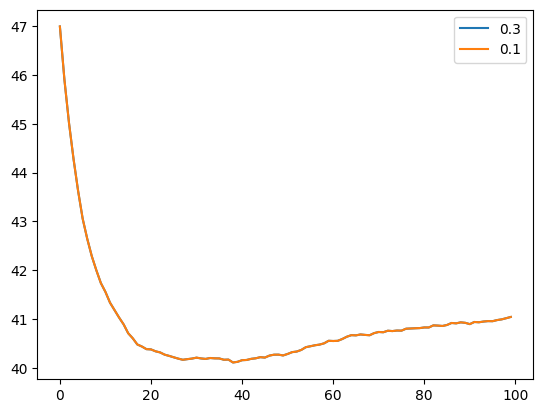

In [155]:
plt.plot(scores['eta=0.3'].num_iter, scores['eta=0.3'].val_rmse,
        label='0.3')
plt.plot(scores['eta=0.1'].num_iter, scores['eta=0.1'].val_rmse,
        label='0.1')
plt.legend();

Answer: Both give equal value